## **MODEL TRAINING AND EVALUATION**

####***Importing the required libraries***

In [23]:
#mathematical computations
import numpy as np

# data manipulation
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Splitting and Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Oversampling
from imblearn.over_sampling import SMOTE
# warnings
import warnings
warnings.filterwarnings('ignore')

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import  KNeighborsClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix


In [4]:
# mount gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# load data
data = pd.read_csv('/content/gdrive/MyDrive/football_prediction/data/cleaned_data.csv')
data.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,result
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False,draw
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False,home_team_wins
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False,home_team_wins
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False,draw
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False,home_team_wins


### **DATA PREPROCESSING AND FEATURE ENGINEERING**

Given that we do not plan to carry out a time series analysis as the time spans are inconsistent, the date column is deemed irrelevant hence we will drop it.

In [6]:
# remove irrelevant columns
data = data.drop(columns=['date'])

# column preview
data.columns

Index(['home_team', 'away_team', 'home_score', 'away_score', 'tournament',
       'city', 'country', 'neutral', 'result'],
      dtype='object')

####****Feature Encoding****

For modelling we require all variables to be in numerical form. Therefore we will label encode our neutral and results column and one hot encode the remaining columns.

In [7]:
# Convert the categorical data into numerical data using one hot encoding
cat_features = ['home_team', 'away_team', 'tournament', 'city', 'country']
data_ohe =  pd.get_dummies(data[cat_features], drop_first=True)


In [8]:
# instantiate label encoder
le = LabelEncoder()

# fit transform the target
encoded_target = le.fit_transform(data["result"])

# fit transform the neutral
encoded_neutral = le.fit_transform(data["neutral"])

In [9]:
# combine encoded target, encoded features and numerical features into a new DataFrame
encoded_data = pd.concat([data_ohe,
                      pd.DataFrame(encoded_target, columns=['result']),
                      pd.DataFrame(encoded_neutral, columns= ['neutral']),
                      data['home_score'],
                      data['away_score']],
                     axis=1
                     )
encoded_data

,home_team_Afghanistan,home_team_Albania,home_team_Alderney,home_team_Algeria,home_team_American Samoa,home_team_Andalusia,home_team_Andorra,home_team_Angola,home_team_Anguilla,home_team_Antigua and Barbuda,...,country_Yugoslavia,country_Zambia,country_Zanzibar,country_Zaïre,country_Zimbabwe,country_Éire,result,neutral,home_score,away_score
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,4,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,2,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,2,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44552,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,1,3,1
44553,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
44554,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
44555,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2


####****Data Splitting****

To avoid the model learning the training data too well and performing poorly on the unseen data, we will split the data into train,test and validation sets.

In [10]:
# drop target column
X = encoded_data.drop('result',axis = 1)

# define target column
y = encoded_data['result']

In [11]:
# train test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

# train validation split
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size = 0.2,random_state=42)

print(f'X_train has {X_train.shape[0]} rows and {X_train.shape[1]} columns')
print(f'X_test has {X_test.shape[0]} rows and {X_test.shape[1]} columns')
print(f'X_val has {X_val.shape[0]} rows and {X_val.shape[1]} columns')

X_train has 28516 rows and 3044 columns
X_test has 8912 rows and 3044 columns
X_val has 7129 rows and 3044 columns


####****Handling Class Imbalance****

Our target column has more home_team_wins classes(48.71%) compared to the draw(23%) and the away_team_wins(28.29%). This will make our model learn very well the home team wins trends on the training data but will perform poorly when presented with new data that does not have the crammed patterns.
To handle this we will oversample the minority classes.

In [12]:
# instantiate smote
smote = SMOTE()

# resample x and y train
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

####****Data Normalization****
This is to ensure that all features have comparable ranges, preventing some features from dominating the learning process.

In [13]:
# Instantiate minmax scaler
scaler = MinMaxScaler()

# fit transform xtrain
X_train_scaled = scaler.fit_transform(X_train_resampled)

# transform the validation
X_val_scaled = scaler.transform(X_val)

# transform test
X_test_scaled = scaler.transform(X_test)

###**MODELLING**

We will start with relatively simple models during this iterative process and work our way up to more complicated ones.

####***Baseline Model***
We will use KNN as our baseline model. It will serve as a starting point or reference for comparison when developing more complex models i.e it will provide a benchmark performance that can be used to evaluate the effectiveness of more advanced models or techniques.

In [17]:
# Initialize the KNN model
knn_model = KNeighborsClassifier()

# Fit the model
knn_model.fit(X_train_scaled, y_train_resampled)

# Make predictions on the train set
train_pred_knn = knn_model.predict(X_train_scaled)

# Make predictions on the validation set
val_pred_knn = knn_model.predict(X_val_scaled)

# Evaluate the model
train_acc_knn = accuracy_score(y_train_resampled, train_pred_knn)
val_acc_knn = accuracy_score(y_val, val_pred_knn)

# Print the accuracy score
print("Train accuracy:", train_acc_knn)
print("Validation accuracy:", val_acc_knn)

Train accuracy: 0.7182369224894998
Validation accuracy: 0.47355870388553795


The knn model achieves a higher accuracy on training set compared to the testing set, which shows there is overfitting.

####***Random Forest Classifier***

In [18]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier()
# Fit the model on the training set
rf_model.fit(X_train_scaled, y_train_resampled)

# Make predictions on training set
train_pred_rf = rf_model.predict(X_train_scaled)

# Make predictions on validation set
val_pred_rf = rf_model.predict(X_val_scaled)

# Evaluate the model performance
train_acc_rf = accuracy_score(y_train_resampled, train_pred_rf)
val_acc_rf = accuracy_score(y_val,val_pred_rf)

# Print the accuracy scores
print("Training Accuracy:", train_acc_rf)
print("Validation Accuracy:", val_acc_rf)

Training Accuracy: 1.0
Validation Accuracy: 0.9879365969981765


The RF model performs well on training set and testing set.

####***XgBoost Classifier***

In [20]:
# Initialize the XGBoost Classifier
xgb_model = XGBClassifier()
# Fit the model on the training set
xgb_model.fit(X_train_scaled, y_train_resampled)

# Make predictions on training set
train_pred_xgb = xgb_model.predict(X_train_scaled)

# Make predictions on testing set
val_pred_xgb = xgb_model.predict(X_val_scaled)

# Evaluate the model performance
train_acc_xgb = accuracy_score(y_train_resampled, train_pred_xgb)
val_acc_xgb = accuracy_score(y_val, val_pred_xgb)

# Print the accuracy scores
print("Training Accuracy:", train_acc_xgb)
print("Validation Accuracy:", val_acc_xgb)

Training Accuracy: 1.0
Validation Accuracy: 1.0


The best performing model is the xgboost with a 100% accuracy on both the train and validation set. For that reason we will use it for our model evaluation.

###**MODEL EVALUATION**

During this phase we will assess the performance and effectiveness of a machine learning model. It will involve measuring how well the model performs on the test dataset or how accurately it can make predictions on new, unseen test data.

In [21]:
# Make predictions on testing set
test_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate the model performance
train_acc_xgb = accuracy_score(y_train_resampled, train_pred_xgb)
test_acc_xgb = accuracy_score(y_test, test_pred_xgb)

# Print the accuracy scores
print("Training Accuracy:", train_acc_xgb)
print("Test Accuracy:", test_acc_xgb)

Training Accuracy: 1.0
Test Accuracy: 0.9998877917414721


On the unseen test data, the model still performs exceptionally well. This demonstrates that the model has not been overfit.

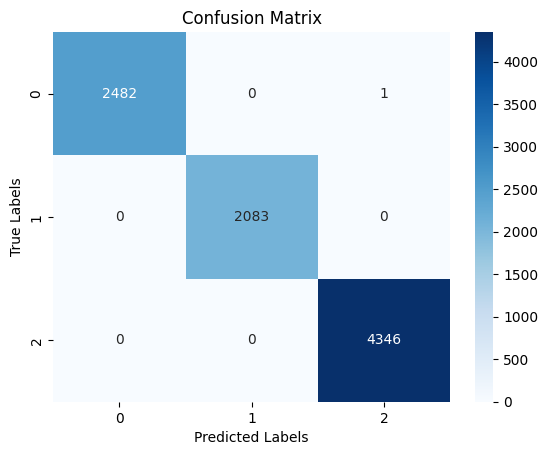

In [27]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, test_pred_xgb)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues",fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

From the confusion matrix,only 1 result has been wrongly classified hence the  ~99% accuracy.